In [1]:
import audio_globals
from AudioDataset import AudioDataset
import Augumentations
import IPython.display as ipd

In [2]:
dataset= AudioDataset(csv_file="esc-50-data.csv", save_dir="data", augumentations=[Augumentations.PITCH_SHIFT,Augumentations.TIME_STRETCH,Augumentations.NOISE])

In [3]:
num_classes = dataset.get_num_classes()
input_shape = dataset.get_spectrogram_shape()
sample_file, sample_spectogram, audio_class, audio_path = dataset.get_random_audio_and_feature()

# Display Spectogram and Audio

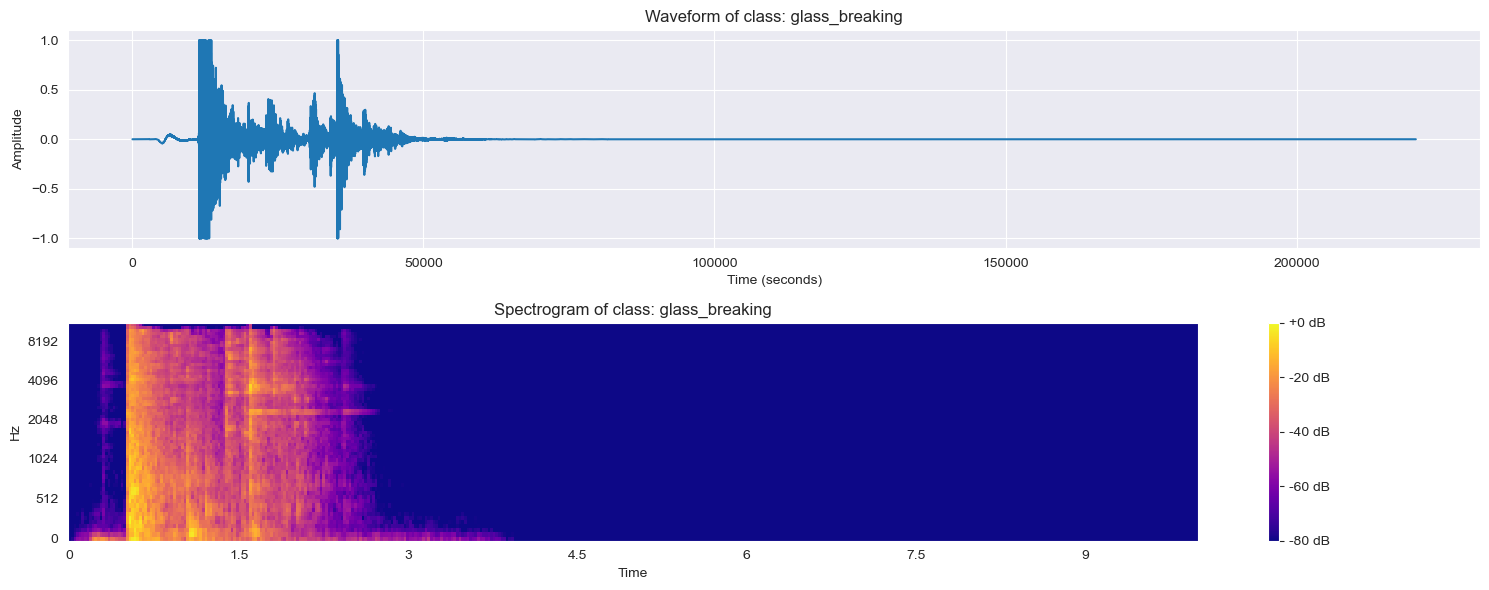

In [4]:
dataset.visualize_spectrogram_audio(sample_spectogram,sample_file, audio_class,cmap="plasma")

# Play sample audio

In [5]:
ipd.display(ipd.Audio(audio_path))

# Before and after augmentation

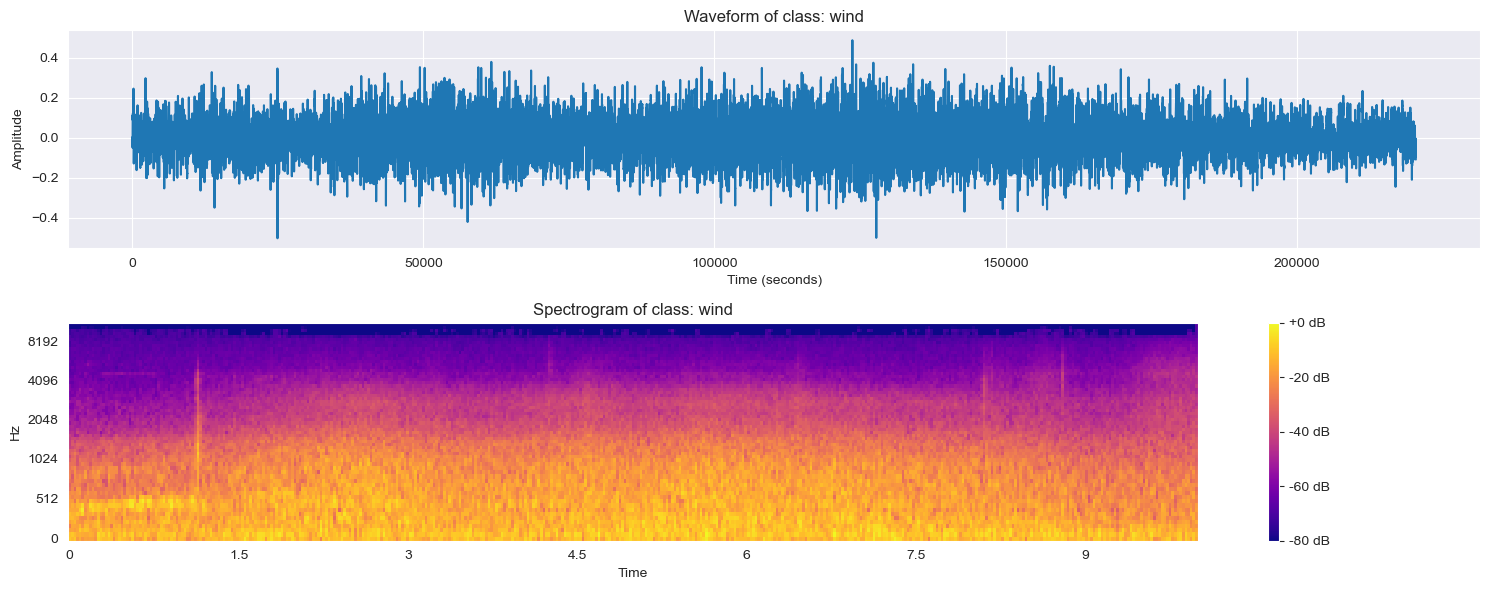

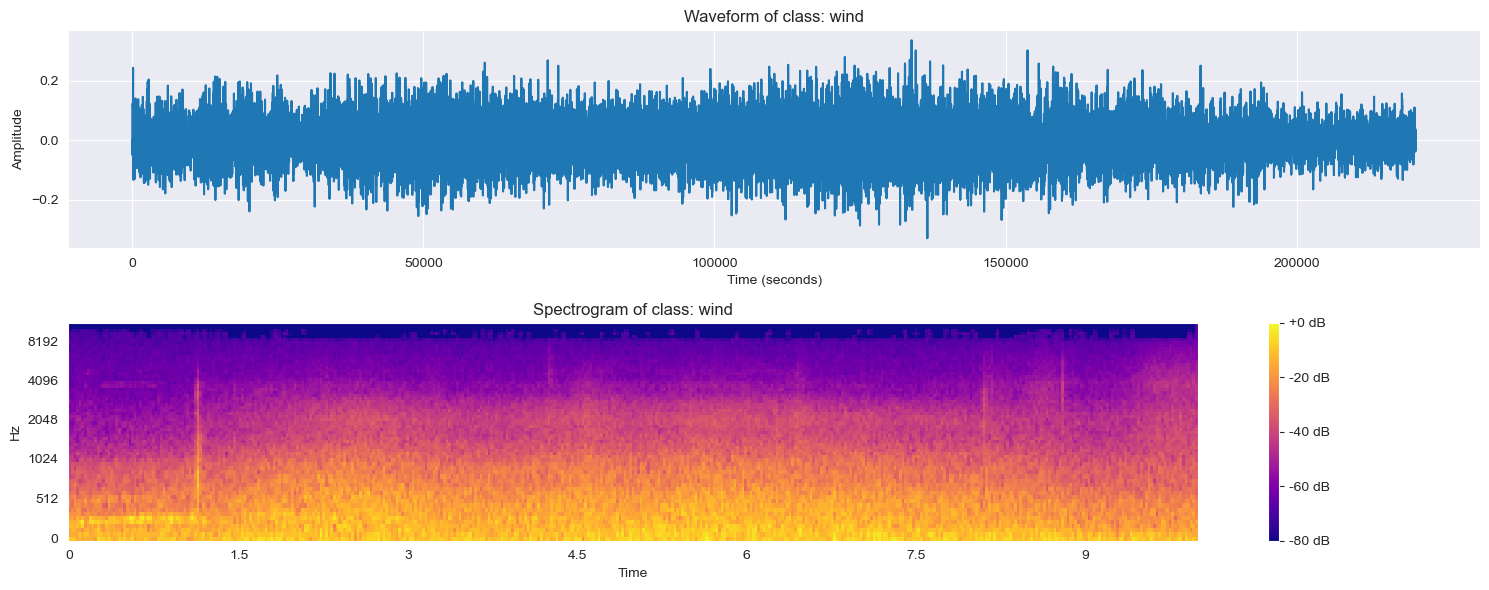

In [6]:
not_augumented_audio,augmented_audio = dataset.visualize_random_spectrogram_audio_augumented(Augumentations.PITCH_SHIFT)

# Audio before and after Augmentation

In [7]:
ipd.display(ipd.Audio(data=augmented_audio,rate=dataset.sr))
ipd.display(ipd.Audio(data=not_augumented_audio,rate=dataset.sr))


In [8]:
train_dataset, val_dataset, test_dataset = dataset.get_datasets()

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout, ReLU,MaxPooling2D
from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from keras.regularizers import l2
import numpy as np

checkpoint_path = "vgg16_1.h5"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=1, mode='auto')
def extract_labels(dataset):
    labels = []
    for _, y in dataset:
        labels.extend(y.numpy())
    return np.array(labels)
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * np.exp(-0.005)
lr_scheduler = LearningRateScheduler(scheduler)
def create_model(num_classes,input_shape,optimizer):
    model = Sequential()
    model.add(Conv2D(input_shape=input_shape, filters=32, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(units=128, activation="relu", kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.5))

    model.add(Dense(units=num_classes, activation="softmax"))

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model
epochs, lrate = 150, 0.0001
decay = lrate/epochs

opt = Adam(learning_rate=lrate)

result = dataset.k_fold_cross_validation(5,64,epochs,callbacks=[lr_scheduler,early,checkpoint],model_func= create_model,opt=opt)


Processing fold 1/5
Processed: data\train
Processed: data\val
Epoch 1/150
    379/Unknown - 32s 72ms/step - loss: 6.2441 - accuracy: 0.0270
Epoch 1: val_accuracy improved from -inf to 0.02601, saving model to vgg16_1.h5
379/379 [==============================] - 33s 75ms/step - loss: 6.2441 - accuracy: 0.0270 - val_loss: 5.8422 - val_accuracy: 0.0260 - lr: 1.0000e-04
Epoch 2/150
379/379 [==============================] - ETA: 0s - loss: 5.6010 - accuracy: 0.0434
Epoch 2: val_accuracy improved from 0.02601 to 0.07022, saving model to vgg16_1.h5
379/379 [==============================] - 31s 73ms/step - loss: 5.6010 - accuracy: 0.0434 - val_loss: 5.4338 - val_accuracy: 0.0702 - lr: 1.0000e-04
Epoch 3/150
378/379 [============================>.] - ETA: 0s - loss: 5.1282 - accuracy: 0.0767
Epoch 3: val_accuracy improved from 0.07022 to 0.10013, saving model to vgg16_1.h5
379/379 [==============================] - 32s 73ms/step - loss: 5.1277 - accuracy: 0.0767 - val_loss: 4.9399 - val_accu

In [10]:
np.mean(result)


0.6464760780334473

In [11]:
np.mean(result)

0.6464760780334473

In [12]:
audio_globals.slice_lenght

30000